In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
# ===== 1. โหลด log =====
log_path = "detections_log.csv"  # path CSV
df = pd.read_csv(log_path)

In [4]:
x = df['person_xy'].values
y = df['person_xy'].values 

In [5]:
import ast
# แปลง string -> tuple -> แยก x, y เป็น float
df[['x_center', 'y_center']] = df['person_xy'].apply(lambda s: pd.Series(ast.literal_eval(s)))
x = df['x_center'].values
y = df['y_center'].values 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame_id        2220 non-null   int64  
 1   timestamp       2220 non-null   object 
 2   video_time_sec  2220 non-null   float64
 3   person_id       2220 non-null   int64  
 4   person_box      2220 non-null   object 
 5   person_xy       2220 non-null   object 
 6   x_center        2220 non-null   float64
 7   y_center        2220 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 138.9+ KB


In [6]:
# ===== 2. โหลดเฟรมแรกของวิดีโอ =====
video_path = r"Vid_test/front_room.mp4"   # path วิดีโอ
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("ไม่สามารถอ่านเฟรมแรกได้")

In [7]:
# แปลง BGR → RGB เพื่อแสดงใน matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w, _ = frame_rgb.shape

In [23]:
x

array([0.4189, 0.1137, 0.8411, ..., 0.2917, 0.7478, 0.3171], shape=(2220,))

In [8]:
# ถ้าตำแหน่งใน log เป็น normalized (0-1) → แปลงเป็นพิกเซล
if x.max() <= 1.0 and y.max() <= 1.0:
    x_pix = x * w
    y_pix = y * h
else:
    x_pix, y_pix = x, y

In [9]:
# ===== 3. ทำ KDE =====
xy = np.vstack([x_pix, y_pix])
kde = gaussian_kde(xy)
xi, yi = np.mgrid[0:w:500j, 0:h:500j]  # grid 500x500
coords = np.vstack([xi.flatten(), yi.flatten()])
density = kde(coords).reshape(xi.shape)

In [26]:
x

array([0.4189, 0.1137, 0.8411, ..., 0.2917, 0.7478, 0.3171], shape=(2220,))

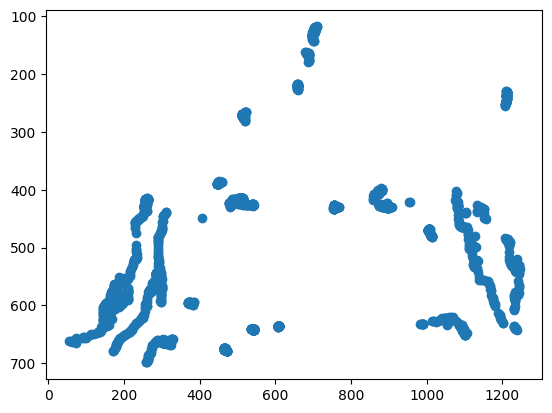

In [10]:
plt.scatter(x*w,y*h)
plt.gca().invert_yaxis()

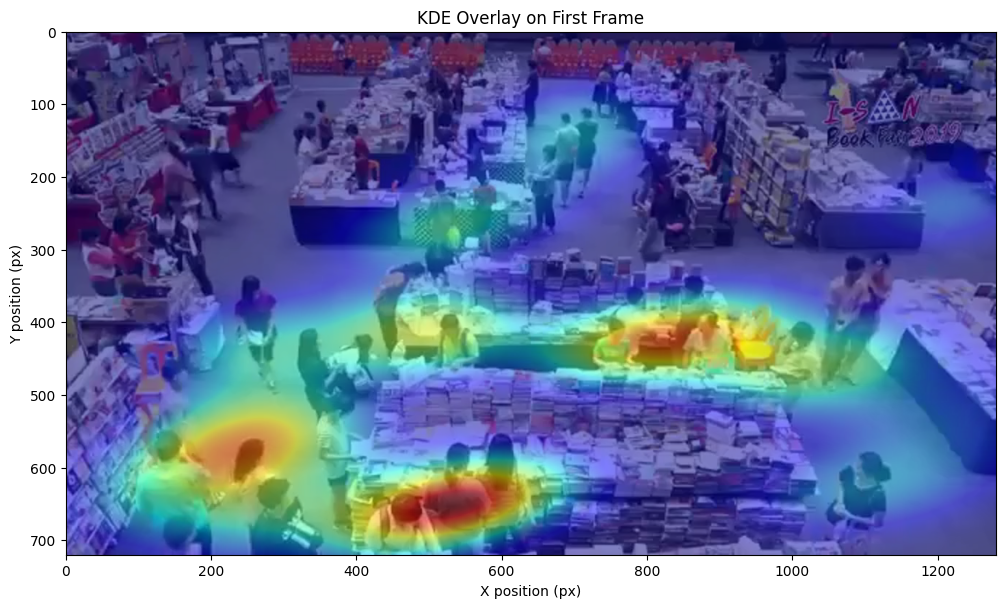

In [ ]:
# ===== 4. แสดงภาพ =====
plt.figure(figsize=(12, 8))

# วาดพื้นหลัง
plt.imshow(frame_rgb, extent=[0, w, h, 0])  # extent เพื่อให้ตรงกับพิกัด pixel

# วาด KDE ทับ (โปร่งใส)
plt.imshow(density.T, cmap='jet', extent=[0, w, h, 0], alpha=0.5, origin='upper')

# # วาดจุด scatter (เพื่อเทียบ)
# plt.scatter(x_pix, y_pix, c='white', s=5, alpha=0.6)

plt.title("KDE Overlay on First Frame")
plt.xlabel("X position (px)")
plt.ylabel("Y position (px)")
plt.show()